# Setting up our Notebook

In [1]:
# Things to import

# Standard data, plotting, time, and mathematical tools
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# Pytorch and Gym
import torch
import torch.nn as nn
from torch.optim import Adam
import gym
from gym import Env
from gym.spaces import Discrete, Box
import torch.nn.functional as F
from collections import deque

# PCA and Training
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Smoothening
from scipy.signal import convolve, gaussian

# Misc
import os
import io
import base64
import time
import glob

from IPython.display import Image

Note, this script heavily follows Listing 6.1, 6.3, 6.4, and 6.4 from the accompanying code for Deep Reinforcement Learning with Python: With PyTorch, TensorFlow and OpenAI Gym.

# Importing the data

In [2]:
# Importing the data

dfs=['Non-Scaled TA Features 1H for BTC.csv']

# Convolutional Neural Network-Based Double Deep Q-Network with Prioritized Experience Replay

## Mathematical Description of a Deep Q-Network

Recall the equation for Q-Learning:

$$ Q(S_t,A_t)=Q(S_t,A_t)+\alpha \left[ R_{t+1}+\gamma \max_{A_{t+1}} Q(S_{t+1},A_{t+1})-Q(S_t,A_t) \right]$$

However, we will be using neural networks to approximate our $Q$-function. We denote the weights and biases of this neural network $\bf{\Theta}$, and our approximation is thus:

$$Q^{\pi}(s,a) \approx {\hat{Q}}(s,a, \bf{\Theta})$$.

We can calculate the loss as the difference squared between the true or target $Q$-function and the appoximation, in Monte Carlo form, as:

$$ {\mathcal{L}}({\bf{\Theta}})=\dfrac{1}{N}\sum_{i=1}^{N}(Q^{\pi}(s,a) - {\hat{Q}}(s,a, {\bf{\Theta}}))^2$$

We use gradient descent to update our parameters $\bf{\Theta}$:

$${\bf{\Theta}}_{t+1}={\bf{\Theta}}_t-\alpha \nabla _{{\bf{\Theta}}_t} {\mathcal{L}}({\bf{\Theta}}_t)$$

However, unlike in normal supervised machine learning, we do not actually know the true function $Q^{\pi}$, so we must approximate it. We do so with another set of weights, ${\bf{\Theta}}^{target}$.

Our new target function is thus:

$$Q^{\pi}(s_i,a_i)=r_i+(1-done_i)\gamma \max_{{a_i}^{'}} {\tilde{Q}}({s_i}^{'},{a_i}^{'},{\bf{\Theta}}^{target}_t)$$

Finally, our parameter update equation, fully wirtten out, becomes:

$${\bf{\Theta}}_{t+1}={\bf{\Theta}}_t +\alpha \dfrac{1}{N}\sum_{i=1}^{N} \left[ r_i+(1-done_i) \gamma \max_{{a_i}^{'}} {\tilde{Q}}({s_i}^{'},{a_i}^{'},{\bf{\Theta}}^{target}_t)-{\hat{Q}}(s_i,a_i, {\bf{\Theta}}_t) \right] \nabla _{{\bf{\Theta}}_t}  {\hat{Q}}(s_i,a_i, {\bf{\Theta}}_t)$$


Our target parameters, ${\bf{\Theta}}^{target}$ are then updated less often so they serve as a stationary target for our loss function.

## Mathematical Description of a Double Deep Q-Network

In a Double Deep Q-Network, the only thing that changes is the target. Recall the target Q-network in DQN:

$$Y^{target}_{DQN}=r_i+(1-done_i)\gamma \max_{{a_i}^{'}} {\tilde{Q}}({s_i}^{'},{a_i}^{'},{\bf{\Theta}}^{target}_t)$$

We will modify this slightly by choosing the next action to be the one that maximizes the $\hat{Q}$, and then feed that into the $\tilde{Q}$ function. This looks like:

$$Y^{target}_{DDQN}=r_i+(1-done_i)\gamma {\tilde{Q}}({s_i}^{'},\max_{{a_i}^{'}} {\hat{Q}}({s_i}^{'},{a_i}^{'},{\bf{\Theta}}_t) ,{\bf{\Theta}}^{target}_t)$$

## Mathematical Description of a Dueling Deep Q-Network

In this modification, we will begin by defining the Advantage:

$$ A^{\pi} (s,a)=Q^{\pi}(s,a)-V(s)^{\pi}$$

From here, we will divide our neural network up and calculate the $Q$-value as follows:

<img src="Graphics/Dueling DQN.png" width="600" height="600" />

## Getting the train/test data

In [3]:
# Defining a function to create PCA matrices

def PCA_creation_train_test(no_components, X_train, X_test):
    
    # Scaling the data with our X_train matrix
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    
    # Fitting the PCA to our X_train matrix
    pca=PCA(n_components=no_components)
    X_train=pca.fit_transform(X_train)

    # Scaling the X_test 
    X_test=scaler.transform(X_test)

    # Transforming the X_test
    X_test=pca.transform(X_test)
    
    return X_train, X_test

In [4]:
# Train and test splitting and scaling
X=pd.read_csv(dfs[0])

X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
X=X.set_index('Date').asfreq('H')

X=X.dropna()
y=X['Percent Change']
X=X.drop('Label', axis=1)
X=X.drop('Percent Change', axis=1)


# Removing the testing data
X_test=X[-4380:] # Getting the last 6 months as the testing data
print('Confirming we have all the columns we want:','\n', X_test.columns)
y_test=y[-4380:].values

X=X[:-4380] # Getting everything but the first 6 months as the training data
y=y[:-4380]

Confirming we have all the columns we want: 
 Index(['BB_upper 10', 'BB_middle 10', 'BB_lower 10', 'Aroon_down 10',
       'Aroon_up 10', 'Aroonosc 10', 'RSI 10', 'NATR 10', 'BB_upper 12',
       'BB_middle 12',
       ...
       'MACD Signal 18', 'MACD Hist18', 'Med Price', 'Chaikin A/D Line',
       'HT Dom Phase', 'HT Dom Period', 'High', 'Low', 'Close', 'Volume'],
      dtype='object', length=101)


In [5]:
# Image creation function

def image_creation(n_steps, X, y):
    X_images=[]
    y_values=[]
    
    for i in range(n_steps, len(X)):
        img=X[i-n_steps,:]
        img=np.vstack((img, X[i-n_steps+1,:]))
        img=np.vstack((img, X[i-n_steps+2,:]))
        img=np.vstack((img, X[i-n_steps+3,:]))
        img=np.vstack((img, X[i-n_steps+4,:]))
        img=np.vstack((img, X[i-n_steps+5,:]))
        img=np.vstack((img, X[i-n_steps+6,:]))
        img=np.vstack((img, X[i-n_steps+7,:]))
        img=np.vstack((img, X[i-n_steps+8,:]))
        img=np.vstack((img, X[i-n_steps+9,:]))
        img=np.vstack((img, X[i-n_steps+10,:]))
        img=np.vstack((img, X[i-n_steps+11,:]))
        X_images.append(img)
        y_values.append(y[i-n_steps+11])
        
    return X_images, np.array(y_values) # Note, this will not include the very last one.

In [6]:
n_steps=12

# First, we create our PCA matrices from the X and X_test
X, X_test=PCA_creation_train_test(20, X, X_test)
    
# Getting the X and X_test matrices' images
X_train, y_train=image_creation(n_steps, X ,y)
X_test, y_test=image_creation(n_steps, X_test, y_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

# Finalizing the shapes
num_classes = 2
input_shape = (n_steps, len(X[0]), 1)

# Add a dimension at the beginning end to make sure images have shape (1, n_steps, n_features)
# Note this is the OPPOSITE of tensorflow
X_train = np.expand_dims(X_train, 1)
X_test = np.expand_dims(X_test, 1)
print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

X_train shape: (26264, 1, 12, 20)
26264 train samples
4368 test samples


## Financial Environment

In [7]:
class FinEnv(Env):
    # A custom Bitcoin trading environment
    def __init__(self, df, y, initial_balance=1000):
        # Define action space and state size and other custom parameters
        self.df = df
        self.y = y
        self.df_total_steps = len(self.df) # How many steps we can possibly take
        self.initial_balance = initial_balance # How much we start with
        self.holding_asset = 0 # We use this to indicate if we are holding an asset or not. 0 is No, 1 is Yes
        self.actions_taken=[] # Keeping a log of our actions
        
        # Orders history contains the our net worth at each step
        self.orders_history = deque(maxlen=self.df_total_steps)
        
        # Market history contains the current market values
        self.market_history = deque(maxlen=1)

        # Action space. 1 is Buy and 0 is Sell
        self.action_space = np.array([0, 1])

        # State size contains the 20 PCA data points per time for 12 time slices
        self.state_size = df[0].shape

    # Reset the state of the environment to an initial state
    def reset(self, env_steps_size=0):
        self.net_worth = self.initial_balance
        self.prev_net_worth = self.initial_balance
        self.holding_asset = 0 # We are not holding anything in the beginning
        self.actions_taken=[] # Keeping a log of our actions
        if env_steps_size > 0: # used for training dataset
            self.start_step = random.randint(0, self.df_total_steps - env_steps_size) # Picks a random step to start from
            self.end_step = self.start_step + env_steps_size # Runs from the randomly chosen step to that step+env_steps we want
        else: # used for testing dataset
            self.start_step = 0
            self.end_step = self.df_total_steps-1

        self.current_step = self.start_step

        self.state = self.df[self.current_step] # State is the state of the market
        # print('Beginning State', self.state)

        return self.state

    # Get the data points for the given current_step
    def _next_observation(self):
        obs = self.df[self.current_step] # Will be what the nn sees to make a decision
        # print('Obs next_observation', obs)
        return obs

    # Execute one time step within the environment
    def step(self, action):
        # print('Action', action)
        # Percent Change
        self.percent_change=self.y[self.current_step]
        # print('Percent Change on this step', self.percent_change)
        
        if action == 1 and self.holding_asset == 0: # Enter the market with all of your current net worth. It is affected
            # by the percent change
            self.net_worth = self.prev_net_worth * (1 + self.percent_change/100)
            self.holding_asset = 1 # You are now holding an asset
            self.actions_taken.append('Bought')
            
        elif action == 1 and self.holding_asset == 1: # You already bought and are waiting to sell. It is affected by the 
            # percent change
            self.net_worth = self.prev_net_worth * (1 + self.percent_change/100)
            # Your holding_asset does not change
            self.actions_taken.append('Buy signal, but we are waiting to sell')
            pass

        elif action == 0 and self.holding_asset == 1: # You leave the market
            self.net_worth = self.prev_net_worth # Your net worth doesn't change
            self.holding_asset = 0 # You are no longer holding any assets
            self.actions_taken.append('Sold')
            
        elif action==0  and self.holding_asset == 0: # You already sold and are waiting for a buy signal
            self.net_worth = self.prev_net_worth # Your net worth doesn't change
            # Your holding_asset does not change
            self.actions_taken.append('Sell signal, but we are waiting to buy')
            pass
        # Reward
        reward=self.net_worth-self.prev_net_worth # Our reward is the change in our net worth
        
        # Updating our prev_net_worth
        self.prev_net_worth = self.net_worth # Updating our prev_net_worth for the next time step
        # print('Net worth after market acts', self.prev_net_worth)

        self.orders_history.append([self.net_worth]) # Adding our net worth to our orders_history
        
        # Leave the market if we have lost half our money
        if self.net_worth <= self.initial_balance/2:
            done = True
        else:
            done = False

        # Stepping into the next state
        if self.current_step == self.end_step:
            # print('We are done stepping', self.current_step)
            obs=[]
            done = True
        else:    
            self.current_step += 1    
            obs = self._next_observation() # Moves us to the next observation
        
        # Set net worths as info so we can retrieve it at the end
        info = self.orders_history
        
        # Return step information   
        return obs, reward, done, info
    # render environment
    def render(self, mode='human'): # 'mode=human' is required for the Keras-RL package
        print(f'Step: {self.current_step}, Beginning Net Worth: {self.net_worth}')

## Random Games

In [8]:
def Random_games(env, episodes = 50, steps=1000):
    for episode in range(episodes): # Runs through however many number of training episodes
        state = env.reset(env_steps_size = steps) # Sets the env_step_size to the batch size

        while True:
            # env.render()

            action = np.random.randint(2, size=1)[0]

            state, reward, done, info = env.step(action)
            # print('Reward', reward)
            # print('End Net Worth', info[-1])
            

            if env.current_step == env.end_step:
                break
                
    return reward

In [9]:
# Playing a random game to confirm our environment is working

# Setting up the environment
df=X_train
y=y_train
train_env = FinEnv(df, y)

# Random Game
Random_games(train_env, episodes = 1, steps=1000)

0.0

## Building the network

### Dueling DQN

In [10]:
# Setting up the device

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [11]:
# Setting up the states and actions
state_shape = train_env.state_size
n_actions = len(train_env.action_space)
print('State Shape',state_shape)
print('Number of actions', n_actions)

State Shape (1, 12, 20)
Number of actions 2


In [12]:
# Creating the Dueling DQN Agent

class DuelingDQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape

        # Conv and Pool Network
    
        self.conv_network = nn.Sequential()
        self.conv_network.add_module('conv', nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=0)) # 'Valid' padding
        self.conv_network.add_module('tanh', nn.Tanh())
        self.conv_network.add_module('avg_pool', nn.AvgPool2d(kernel_size=2, stride=2, padding=0))
        self.conv_network.add_module('flatten', nn.Flatten())

        # MLP Network for both Value and Advantage to go through

        self.fc_network = nn.Sequential()
        self.fc_network.add_module('linear1', nn.Linear(2880, 512))
        self.fc_network.add_module('tanh1', nn.Tanh())
        self.fc_network.add_module('Dropout1', nn.Dropout(0.6))
        self.fc_network.add_module('linear2', nn.Linear(512, 512))
        self.fc_network.add_module('tanh2', nn.Tanh())
        self.fc_network.add_module('Dropout2', nn.Dropout(0.6))

        # Value Layer
        self.value = nn.Linear(512, 1)

        # Advantage Layer
        self.adv = nn.Linear(512, n_actions)

    def forward(self, state_t):
        # pass the state at time t through the network to get Q(s,a)
        x = self.conv_network(state_t)
        x = self.fc_network(x)
        v = self.value(x)
        adv = self.adv(x)
        adv_avg = torch.mean(adv, dim=1, keepdim=True)
        qvalues = v + adv - adv_avg
        return qvalues

    def get_qvalues(self, states):
        # input is an array of states in numpy and output is Qvals as numpy array
        states = torch.tensor(states, device=device, dtype=torch.float32)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        # sample actions from a batch of q_values using epsilon greedy policy
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [13]:
# Instantiation of the agent

agent = DuelingDQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

In [14]:
# Evaluation function

def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, info = env.step(action)
            reward += r
            if done:
                break

        rewards.append(reward)
    return np.mean(rewards), info

## Prioritized Experience Replay

### Mathematical Description of Prioritized Experience Replay

Replay buffer is very important in DQN to break the correlation between samples. We use a behavior policy ($\epsilon-greedy$) to sample from the environment and store the transitions $(s,a,r,s',done)$ into a buffer. These samples are used multiple times in a learning making the process sample efficient. 

We will be using prioritized version of experience replay. 

The interface to PrioritizedReplayBuffer is:
* `exp_replay.add(state, action, reward, next_state, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns states, actions, rewards, next_states and done_flags for `batch_size` random samples.
* `update_priorities(idxs, new_priorities)` - returns nothing. 
* `len(exp_replay)` - returns number of elements stored in replay buffer.

In usual replay buffer, we select training batch with equal probability of selection for each sample/transition stored in the buffer. However, in Prioritized replay, we assign an importance score $p_i$ to each sample/transition. One approach to importance score is to use the absolute value of TD error $\delta_i$ with addition of small constant $\epsilon$ to avoid the edge case of error being zero and not picked up again ever.  

$$ p_i = |\delta_i| +\epsilon$$

$$\delta_i = r_i + \left[ (1-done_i)  \gamma   \max_{a_i^{'}} \tilde{Q}(s_{i}^{'},a_i^{'},{\bf{\Theta}}^{target}_t) \right] – \hat{Q}(s_i,a_i,{\bf{\Theta}}_t)$$

Note: We have the regular DQN error written above, but when combining the Double DQN and PER, this error will change to accomodate the changes in the Double DQN.

At the time of picking the batch samples from buffer, the individual importance scores for samples are converted to probability which defines the probability of a sample being picked:

$$P(i) = \frac{p_i^{\alpha}}{\sum_i p_i^{\alpha}}$$

$\alpha$ is a hyper parameter and in the paper in which this method was developed, a value of 0.6 was found to work the best. We are using the same value in our code here.

TD error for the samples chosen in the batch is used to calculate the loss and $\nabla_w(L)$. The TD error is also used to update the importance score $p_i$ of the samples back in the buffer. 

The probability $P(i)$ is also used to calculate a weight, an importance sampling value, to adjust for the fact that samples now have a non uniform probability of being picked. The weight vector for batch samples as given below:

$$w_i = \left(\frac{1}{N}\frac{1}{P(i)} \right)^\beta$$

The value of $\beta=0.4$ has been taken from the paper in which this was originally implemented, same as with $\alpha$.

Now, we normalize our weight:

$$w_i=\dfrac{1}{\max_{i} w_i} w_i$$

Finally, our loss function is now:

$${\mathcal{L}}({\bf{\Theta}}_t, {\bf{\Theta}}^{target}_t)= \dfrac{1}{N}\sum_{i=1}^{N} \left[ \left( r_i+[(1-done_i) \gamma \max_{{a_i}^{'}} {\tilde{Q}}({s_i}^{'},{a_i}^{'},{\bf{\Theta}}^{target}_t)]-{\hat{Q}}(s_i,a_i, {\bf{\Theta}}_t) \right) w_i \right] ^2$$

From this, we can calculate our parameter update equation, which we omit for brevity.

In [15]:
class PrioritizedReplayBuffer:
    def __init__(self, size, alpha=0.6, beta=0.4):
        self.size = size #max number of items in buffer
        self.buffer =[] #array to holde buffer
        self.next_id = 0
        self.alpha = alpha
        self.beta = beta
        self.priorities = np.ones(size)
        self.epsilon = 1e-5
    
    def __len__(self):
        return len(self.buffer)
    
    def add(self, state, action, reward, next_state, done):
        item = (state, action, reward, next_state, done)
        max_priority = self.priorities.max()
        if len(self.buffer) < self.size:
            self.buffer.append(item)
        else:
            self.buffer[self.next_id] = item
        self.priorities[self.next_id] = max_priority
        self.next_id = (self.next_id + 1) % self.size
        
    def sample(self, batch_size):
        priorities = self.priorities[:len(self.buffer)]
        probabilities = priorities ** self.alpha
        probabilities /= probabilities.sum()
        N = len(self.buffer)
        weights = (N * probabilities) ** (-self.beta)
        weights /= weights.max()

        idxs = np.random.choice(len(self.buffer), batch_size, p=probabilities)

        samples = [self.buffer[i] for i in idxs]
        states, actions, rewards, next_states, done_flags = list(zip(*samples))
        weights = weights[idxs]
        
        
        return  (np.array(states), np.array(actions), np.array(rewards), 
                np.array(next_states), np.array(done_flags), np.array(weights), np.array(idxs))
        
    def update_priorities(self, idxs, new_priorities):
        self.priorities[idxs] = new_priorities+self.epsilon

In [16]:
def play_and_record(start_state, agent, env, exp_replay, n_steps=1):

    s = start_state
    sum_rewards = 0

    # Play the game for n_steps and record transitions in buffer
    for _ in range(n_steps):
        qvalues = agent.get_qvalues([s])
        a = agent.sample_actions(qvalues)[0]        
        next_s, r, done, _ = env.step(a)
        sum_rewards += r
        exp_replay.add(s, a, r, next_s, done)
        if done:
            s = env.reset()
        else:
            s = next_s
        
    return sum_rewards, s

### Target network

In [17]:
target_network = DuelingDQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

### Learning with Double DQN

In [18]:
def compute_td_loss_priority_replay_ddqn(agent, target_network, replay_buffer,
                                    states, actions, rewards, next_states, done_flags, weights, buffer_idxs,
                                    gamma=0.99, device=device):

    # convert numpy array to torch tensors
    states = torch.tensor(states, device=device, dtype=torch.float)
    actions = torch.tensor(actions, device=device, dtype=torch.long)
    rewards = torch.tensor(rewards, device=device, dtype=torch.float)
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    done_flags = torch.tensor(done_flags.astype('float32'),device=device,dtype=torch.float)
    weights = torch.tensor(weights, device=device, dtype=torch.float)

    # get q-values for all actions in current states
    # use agent network
    predicted_qvalues = agent(states)

    # compute q-values for all actions in next states
    # use target network
    predicted_next_qvalues = target_network(next_states)
    
    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[range(
        len(actions)), actions]
    
    # Same up to here as the regular DQN

    # compute q-values for all actions in next states
    # use agent network (online network)
    qvalues_next_states = agent(next_states).detach()
    
    # compute Q argmax(next_states, actions) using predicted next q-values
    _,a1max = torch.max(qvalues_next_states, dim=1)

    #use target network to calculate the q value for best action chosen above
    qvalues_next_states_target = target_network(next_states)

    qvalues_next_states_target_max = qvalues_next_states_target[range(len(a1max)), a1max]

    # compute "target q-values" 
    target_q = rewards + gamma * qvalues_next_states_target_max * (1-done_flags)

    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions - target_q).pow(2))

    return loss

## Main loop

In [19]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [20]:
# set a seed
seed = 100
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [21]:
# Setting up the agent, environment, and target networks

df=X_train
y=y_train
train_env = FinEnv(df, y)
state_shape = train_env.state_size
n_actions = len(train_env.action_space)
print('State Shape',state_shape)
print('Number of actions', n_actions)

state = train_env.reset()

agent = DuelingDQNAgent(state_shape, n_actions, epsilon=1).to(device)
target_network = DuelingDQNAgent(state_shape, n_actions, epsilon=1).to(device)
target_network.load_state_dict(agent.state_dict())

State Shape (1, 12, 20)
Number of actions 2


<All keys matched successfully>

In [22]:
# let us fill experience replay with some samples using full random policy

exp_replay = PrioritizedReplayBuffer(10**4)
for i in range(100):
    play_and_record(state, agent, train_env, exp_replay, n_steps=10**2)
    if len(exp_replay) == 10**4:
        break
print('Number of experiences in Prioritized Replay Buffer',len(exp_replay))

C:\Users\chris\AppData\Local\Temp\ipykernel_20348\3655508342.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:210.)
  states = torch.tensor(states, device=device, dtype=torch.float32)


Number of experiences in Prioritized Replay Buffer 10000


In [23]:
# Training parameters

timesteps_per_epoch = 1
batch_size = 32
total_steps = 40000

# Optimizer
opt = torch.optim.Adam(agent.parameters(), lr=1e-5)

# Exploration Epsilon
start_epsilon = 1
end_epsilon = 0.05
eps_decay_final_step = 2 * 10**4

# Frequency for logging and updating
loss_freq = 20
refresh_target_network_freq = 100
eval_freq = 1000

# Gradient Clipping
max_grad_norm = 5000

# Logging
mean_rw_history = []
td_loss_history = []

In [24]:
# Epsilon Schedule and Smoothening functions

def epsilon_schedule(start_eps, end_eps, step, final_step):
    return start_eps + (end_eps-start_eps)*min(step, final_step)/final_step

def smoothen(values):
    kernel = gaussian(100, std=100)
    kernel = kernel / np.sum(kernel)
    return convolve(values, kernel, 'valid')

In [1]:
# Training

state = train_env.reset()
for step in range(total_steps + 1):
    
    # reduce exploration as we progress
    agent.epsilon = epsilon_schedule(start_epsilon, end_epsilon, step, eps_decay_final_step)

    # take timesteps_per_epoch and update experience replay buffer
    _, state = play_and_record(state, agent, train_env, exp_replay, timesteps_per_epoch) # At the end
    # of this function, the state has been moved forward or restarted

    # train by sampling batch_size of data from experience replay
    states, actions, rewards, next_states, done_flags, weights, idxs = exp_replay.sample(batch_size)
    

    # loss = <compute TD loss>
    loss = compute_td_loss_priority_replay_ddqn(agent, target_network, exp_replay,
                           states, actions, rewards, next_states, done_flags, weights, idxs,              
                           gamma=0.25,
                           device=device)

    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    opt.step()
    opt.zero_grad()

    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())

    if step % refresh_target_network_freq == 0:
        # Load agent weights into target_network
        target_network.load_state_dict(agent.state_dict())

    if step % eval_freq == 0:
        # eval the agent
        mean_rw_history.append(evaluate(train_env, agent, n_games=3, greedy=True, t_max=1000)
        )

        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" %
              (len(exp_replay), agent.epsilon))

#         plt.figure(figsize=[16, 5])
#         plt.subplot(1, 2, 1)
#         plt.title("Mean reward per episode")
#         plt.plot(mean_rw_history)
#         plt.grid()

#         assert not np.isnan(td_loss_history[-1])
#         plt.subplot(1, 2, 2)
#         plt.title("TD loss history (smoothened)")
#         plt.plot(smoothen(td_loss_history))
#         plt.grid()

#         plt.show()

Text(0.5, 1.0, 'Smoothened TD Loss')

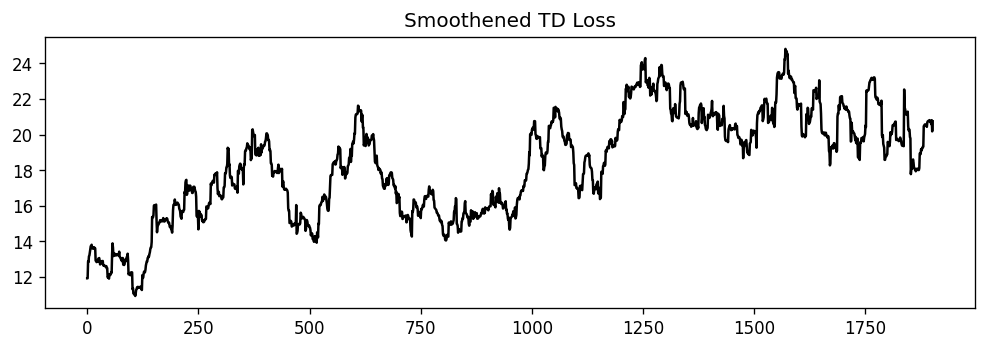

In [26]:
TD_Loss=smoothen(td_loss_history)
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(TD_Loss, color='black')
plt.title('Smoothened TD Loss')

### Performance Evaluation

#### Training Environment

In [27]:
n_games=1 # Given the deterministic nature of this algorithm and the environment, this doesn't matter, so we set
# it to 1 for faster computation
t_max=len(X_train)-1

final_score, net_worths = evaluate(
  train_env,
  agent, n_games=n_games, greedy=True, t_max=t_max
)
print('Average Rewards after',t_max, 'steps in',n_games, 'game(s) is:', final_score)

Average Rewards after 26263 steps in 1 game(s) is: 8426.903953608478


#### Testing Environment

In [28]:
df=X_test
y=y_test
max_length=len(df)
test_env = FinEnv(df, y)

n_games=1
t_max=max_length

final_score, net_worths = evaluate(
  test_env,
  agent, n_games=n_games, greedy=True, t_max=t_max
)
print('Average Rewards after',t_max, 'steps in',n_games, 'game(s) is:', final_score)

Average Rewards after 4368 steps in 1 game(s) is: 602.0685270413987


Text(0.5, 1.0, 'Value of 1000 Dollars')

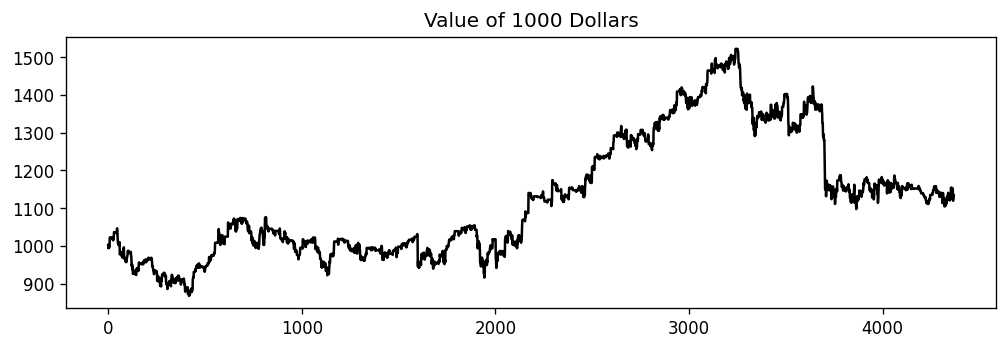

In [29]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(net_worths, color='black')
plt.title('Value of 1000 Dollars')

#### Saving and Reloading the Agent

In [31]:
# Saving an agent

torch.save(agent, 'Models/CNN DQN gamma_0.25 3 BTC.h5')

In [29]:
# Loading an agent

agent = torch.load('Models/CNN DQN gamma_0.25 2 BTC.h5')

# Confirming it has the architecture we want
agent.eval()

DuelingDQNAgent(
  (conv_network): Sequential(
    (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (tanh): Tanh()
    (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_network): Sequential(
    (linear1): Linear(in_features=2880, out_features=512, bias=True)
    (tanh1): Tanh()
    (Dropout1): Dropout(p=0.6, inplace=False)
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (tanh2): Tanh()
    (Dropout2): Dropout(p=0.6, inplace=False)
  )
  (value): Linear(in_features=512, out_features=1, bias=True)
  (adv): Linear(in_features=512, out_features=2, bias=True)
)

#### Model Evaluation

In [24]:
# Models to evaluate

models=['Models/CNN DQN gamma_0 BTC.h5', 'Models/CNN DQN gamma_0.15 BTC.h5', 'Models/CNN DQN gamma_0.25 BTC.h5',
       'Models/CNN DQN gamma_0.35 BTC.h5', 'Models/CNN DQN gamma_0.5 BTC.h5', 'Models/CNN DQN gamma_0.75 BTC.h5',
       'Models/CNN DQN gamma_0.8 BTC.h5', 'Models/CNN DQN gamma_0.9 BTC.h5', 'Models/CNN DQN gamma_0.95 BTC.h5',
       'Models/CNN DQN gamma_1 BTC.h5']

In [27]:
# Evaluating our models

for model in models:
    print(model)
    agent = torch.load(model)
    agent.eval()
    df=X_test
    y=y_test
    max_length=len(df)
    test_env = FinEnv(df, y)

    n_games=1 # Given the deterministic nature of this algorithm and the environment, this doesn't matter, so we set
# it to 1 for faster computation
    t_max=max_length

    final_score, net_worths = evaluate(
      test_env,
      agent, n_games=n_games, greedy=True, t_max=t_max
    )
    print('Average Rewards after',t_max, 'steps in',n_games, 'game(s) is:', final_score)
    print('\n')


Models/CNN DQN gamma_0 BTC.h5
Average Rewards after 4368 steps in 1 game(s) is: 398.72210801207666


Models/CNN DQN gamma_0.15 BTC.h5
Average Rewards after 4368 steps in 1 game(s) is: 406.97988090586955


Models/CNN DQN gamma_0.25 BTC.h5
Average Rewards after 4368 steps in 1 game(s) is: 514.0786949635524


Models/CNN DQN gamma_0.35 BTC.h5
Average Rewards after 4368 steps in 1 game(s) is: 449.05726790541576


Models/CNN DQN gamma_0.5 BTC.h5
Average Rewards after 4368 steps in 1 game(s) is: 409.38067483164446


Models/CNN DQN gamma_0.75 BTC.h5
Average Rewards after 4368 steps in 1 game(s) is: 332.1139630280495


Models/CNN DQN gamma_0.8 BTC.h5
Average Rewards after 4368 steps in 1 game(s) is: 344.24174270706385


Models/CNN DQN gamma_0.9 BTC.h5
Average Rewards after 4368 steps in 1 game(s) is: 251.699453030963


Models/CNN DQN gamma_0.95 BTC.h5
Average Rewards after 4368 steps in 1 game(s) is: 250.11478161224773


Models/CNN DQN gamma_1 BTC.h5
Average Rewards after 4368 steps in 1 game(s

We see that the best model is the one with $\gamma=0.25$. So, we will train three more models to see their behavior.

In [32]:
# Models to evaluate

models=['Models/CNN DQN gamma_0.25 BTC.h5', 'Models/CNN DQN gamma_0.25 2 BTC.h5', 'Models/CNN DQN gamma_0.25 3 BTC.h5',
       'Models/CNN DQN gamma_0.25 4 BTC.h5']

In [33]:
# Evaluating our models

for model in models:
    print(model)
    agent = torch.load(model)
    agent.eval()
    df=X_test
    y=y_test
    max_length=len(df)
    test_env = FinEnv(df, y)

    n_games=1 # Given the deterministic nature of this algorithm and the environment, this doesn't matter, so we set
# it to one for faster computation
    t_max=max_length

    final_score, net_worths = evaluate(
      test_env,
      agent, n_games=n_games, greedy=True, t_max=t_max
    )
    print('Average Rewards after',t_max, 'steps in',n_games, 'game(s) is:', final_score)
    print('\n')


Models/CNN DQN gamma_0.25 BTC.h5
Average Rewards after 4368 steps in 1 game(s) is: 514.0786949635524


Models/CNN DQN gamma_0.25 2 BTC.h5
Average Rewards after 4368 steps in 1 game(s) is: 557.8375262179459


Models/CNN DQN gamma_0.25 3 BTC.h5
Average Rewards after 4368 steps in 1 game(s) is: 556.1278458356089


Models/CNN DQN gamma_0.25 4 BTC.h5
Average Rewards after 4368 steps in 1 game(s) is: 499.3477331670656




We see consistent results, all higher than any of the other one-of models with different $\gamma$s